
## Contextualização 

MACHINE LEARNING: 
WAVES


Equipe:

*   Thayna de Rezende Euzébio
*   Thiago Marcon Marcelino Texeira
*   Vinícius de Souza Margotti
*   Vinícius Medeiros Rodrigues Chede 
*   Wédley Santos Leandro



## Contextualizando


* No setor da indústria manufatureira de objetos cerâmicos os principais problemas enfrentados são identificação rápida e eficiente de pequenas deformações/fissuras. 

* Tipos de fissura podem acontecer na estrutura interna das peças e que não são facilmente identificadas através de uma inspeção visual.

* Hoje na indústria cerâmica o processo de controle de qualidade para defeitos não-visuais é tradicionalmente realizado de forma manual.

## Finalidade

O projeto consiste em ler a base de dados Wav e pré-processar os dados criando um data frame com seus respectivos rótulos e extraindo características dos áudios, deve ser montado em seguida um modelo de machine learning com base em hiperparâmetros definidos pelas análise dos dados.


## Importe as bibliotecas para realização do projeto 

  Bibliotecas necessárias: 
	 

In [ ]:
#Importações das bibliotecas necessárias para o projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, join as pjoin
from pathlib import Path
import audioop
from scipy.io import wavfile
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,confusion_matrix
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

## Crie DataFrame com os dados com seus respectivos rótulos 

Percorrer as pastas com áudios de telhas boas e ruins, criar um dataset com a extração de das características.

### Extração de características dos áudios 
*   Valor Mínimo do sinal 
*   Valor Máximo do sinal 
*   Valor médio 
*   Força 
*   Valor RMS
*   Variância 
*   Fator de Forma 
*   Fator de crista 
*   Energia 


In [ ]:
#Função responsável por montar o dataset com métricas dos audios, dentre elas:

def calMetrics(df,data,samplerate) :
        length = data.shape[0] / samplerate
        time = np.linspace(0., length, data.shape[0])
        minValueSignal = np.min(data)
        maxValueSignal = np.max(data)
        meanValueSignal = np.mean(data)
        force = np.sum(data)
        rms2 = audioop.rms(data, 2)
        variance = np.var(data)
        shapeFactor = maxValueSignal/rms2
        crestFactor = maxValueSignal/meanValueSignal
        energy = np.sum(data**2)
        
        df = df.append(
          {
          'data': data,
          'lenght': length,
          'time': time,
          'min': minValueSignal,
          'max': maxValueSignal,
          'mean': meanValueSignal,
          'force': force, 
          'rms': rms2,
          'variance': variance,
          'form_factor': shapeFactor,
          'crest_factor': crestFactor,
          'energy': energy
          }, 
        ignore_index=True) 
        return df

## Análise e pré-processamento numérica dos dados 

Realize uma análise nos dados com as ferramentas com as funções  head(), describe(), info(). Caso seja necessário aplique técnicas para tratar dados nulos, dados categóricos e outliers.   

In [ ]:
##Leitura dos audios bons e ruins e criação dos dataframes utilizando a função CalMetrics

colums = ['data', 'lenght','time','min','max','mean','force','rms','variance','form_factor','crest_factor','energy'];
dfGood = pd.DataFrame(columns=colums)
dfBad = pd.DataFrame(columns=colums)

base_path = Path(r"good")

##pra cada gravação vai retornar as metricas

for wav_file_path in base_path.glob("*.wav"):
   ##Calculando métricas do audio bopm
   samplerate, data = wavfile.read(wav_file_path)
   ##chama função que montar o dataset com métricas dos audios
   dfGood = calMetrics(dfGood,data,samplerate)
   dfGood['good'] = 1

base_path = Path(r"bad")

for wav_file_path in base_path.glob("*.wav"):
   ##Calculando métricas do audio ruim
    samplerate, data = wavfile.read(wav_file_path)
    ##chama função que montar o dataset com métricas dos audios
    dfBad = calMetrics(dfBad,data,samplerate)
    dfBad['good'] = 0

In [ ]:
dfGood.head(2)

,data,lenght,time,min,max,mean,force,rms,variance,form_factor,crest_factor,energy,good
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.4,"[0.0, 2.2728564122961533e-05, 4.54571282459230...",-32767,32511,-2.069261,-36419,6688,4.474096e+07,4.861094,-15711.403388,18608009,1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.4,"[0.0, 2.2728564122961533e-05, 4.54571282459230...",-32767,32511,2.457500,43252,6717,4.512923e+07,4.840107,13229.298067,16298932,1


In [ ]:
dfBad.head(2)


,data,lenght,time,min,max,mean,force,rms,variance,form_factor,crest_factor,energy,good
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.4,"[0.0, 2.2728564122961533e-05, 4.54571282459230...",-32767,32511,0.871420,15337,4195,1.759959e+07,7.749940,37308.052422,6439693,0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.4,"[0.0, 2.2728564122961533e-05, 4.54571282459230...",-32767,32511,-2.006193,-35309,4907,2.408527e+07,6.625433,-16205.318757,8666541,0


In [ ]:
dfGood.describe()

,lenght,mean,variance,form_factor,crest_factor,good
count,1.400000e+02,140.000000,1.400000e+02,140.000000,1.400000e+02,140.0
mean,4.000000e-01,0.164525,4.304080e+07,4.992592,3.054399e+05,1.0
std,1.114209e-16,4.599169,5.838097e+06,0.364460,3.459128e+06,0.0
min,4.000000e-01,-15.649545,2.533052e+07,4.313520,-7.849021e+05,1.0
25%,4.000000e-01,-3.322926,3.955113e+07,4.757446,-9.446639e+03,1.0
50%,4.000000e-01,0.060369,4.335639e+07,4.937891,2.501660e+03,1.0
75%,4.000000e-01,2.789830,4.671204e+07,5.169710,1.179570e+04,1.0
max,4.000000e-01,14.718523,5.681086e+07,6.460851,4.087097e+07,1.0


In [ ]:
dfBad.describe()

,lenght,mean,variance,form_factor,crest_factor,good
count,1.400000e+02,140.000000,1.400000e+02,140.000000,1.400000e+02,140.0
mean,4.000000e-01,-0.076646,2.371815e+07,6.785953,4.069422e+03,0.0
std,1.114209e-16,1.998320,5.533302e+06,0.789158,3.052319e+05,0.0
min,4.000000e-01,-5.468580,1.240638e+07,5.417597,-2.151104e+06,0.0
25%,4.000000e-01,-1.242528,1.965499e+07,6.262690,-2.663064e+04,0.0
50%,4.000000e-01,-0.064176,2.405532e+07,6.629489,-6.279449e+03,0.0
75%,4.000000e-01,1.071250,2.695628e+07,7.279696,2.666100e+04,0.0
max,4.000000e-01,4.638409,3.602399e+07,8.931593,2.058250e+06,0.0


In [ ]:
dfGood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   data          140 non-null    object 
 1   lenght        140 non-null    float64
 2   time          140 non-null    object 
 3   min           140 non-null    object 
 4   max           140 non-null    object 
 5   mean          140 non-null    float64
 6   force         140 non-null    object 
 7   rms           140 non-null    object 
 8   variance      140 non-null    float64
 9   form_factor   140 non-null    float64
 10  crest_factor  140 non-null    float64
 11  energy        140 non-null    object 
 12  good          140 non-null    int64  
dtypes: float64(5), int64(1), object(7)
memory usage: 14.3+ KB


In [ ]:
dfBad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   data          140 non-null    object 
 1   lenght        140 non-null    float64
 2   time          140 non-null    object 
 3   min           140 non-null    object 
 4   max           140 non-null    object 
 5   mean          140 non-null    float64
 6   force         140 non-null    object 
 7   rms           140 non-null    object 
 8   variance      140 non-null    float64
 9   form_factor   140 non-null    float64
 10  crest_factor  140 non-null    float64
 11  energy        140 non-null    object 
 12  good          140 non-null    int64  
dtypes: float64(5), int64(1), object(7)
memory usage: 14.3+ KB


## Análise gráfica dos dados

 *  Plot gráficos dos sons no domínio do tempo (Comparativo de uma telha boa e uma telha ruim). 

 *  Plot gráficos das features (Comparativo de uma telha boa e uma telha ruim)

In [ ]:
##Função para plot no domínio do tempo
def plotDomainTime(df,index,color):
    plt.figure(figsize=(20, 5))
    plt.plot(df['time'][index], df['data'][index],color=color)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.show()

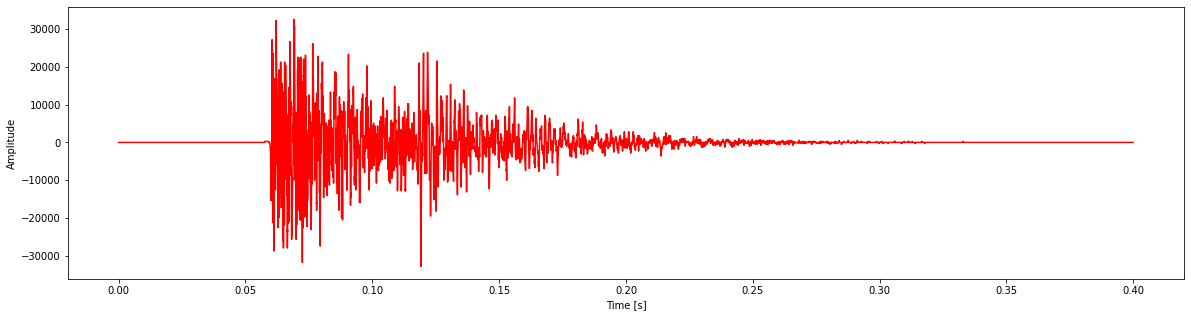

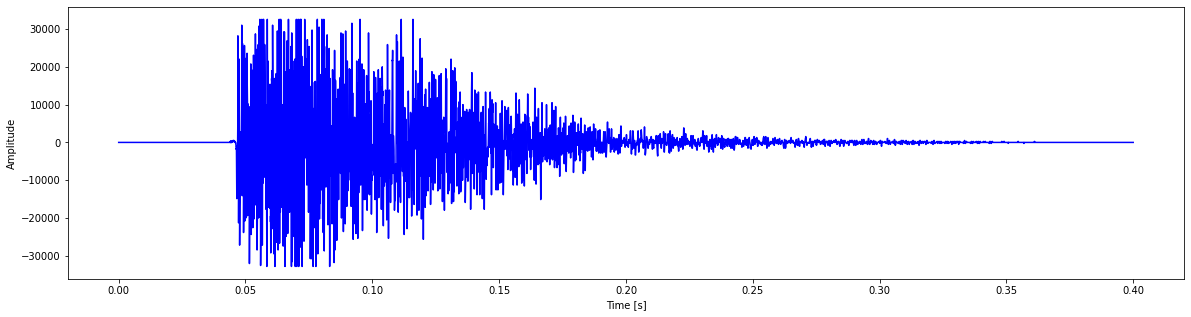

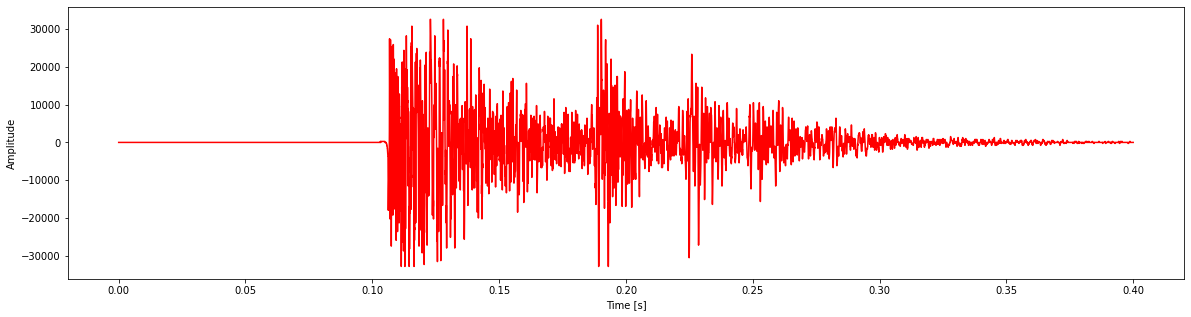

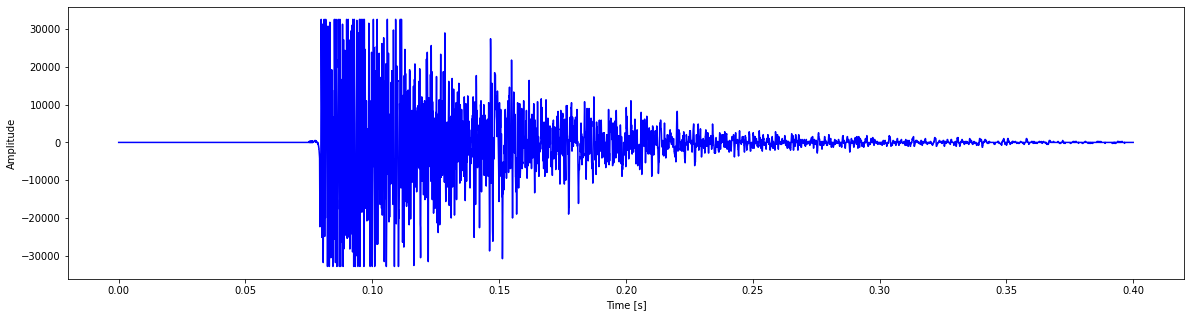

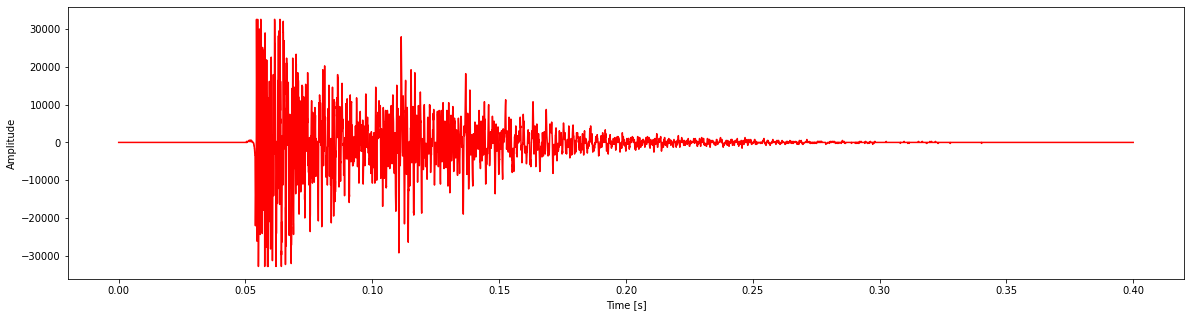

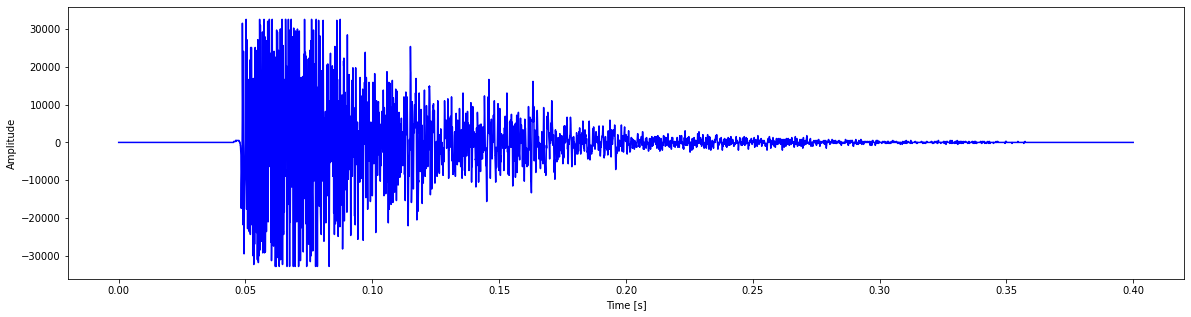

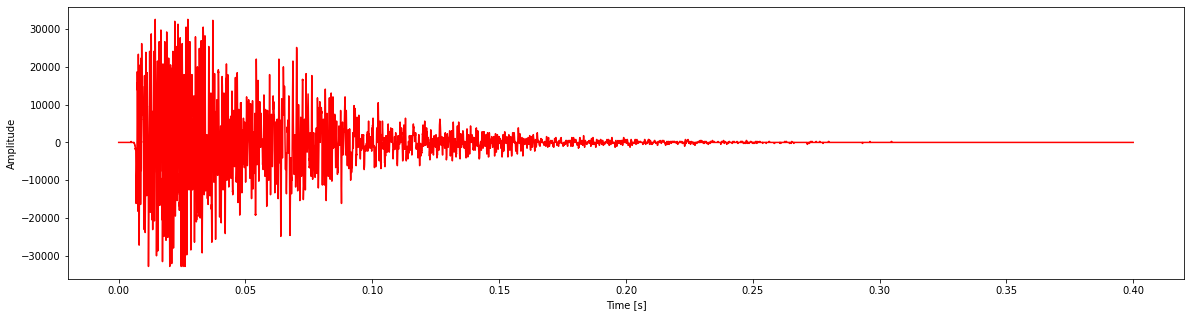

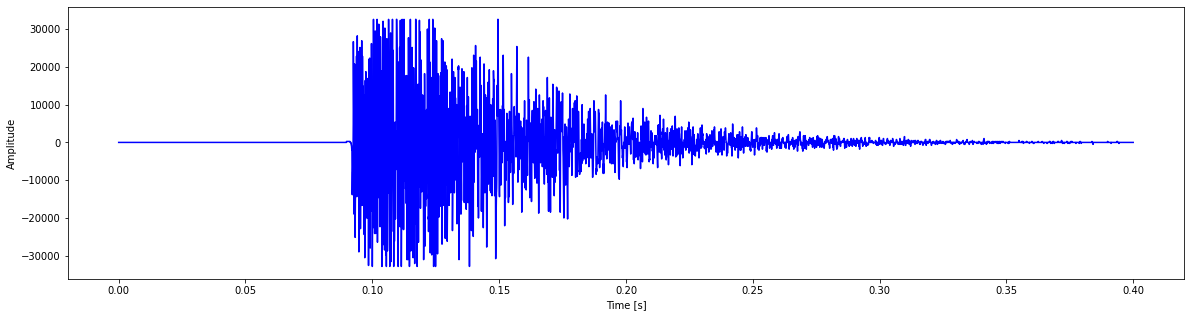

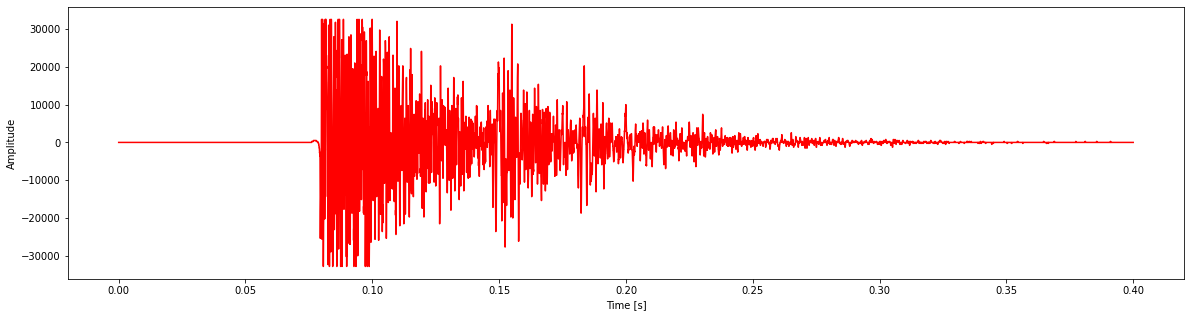

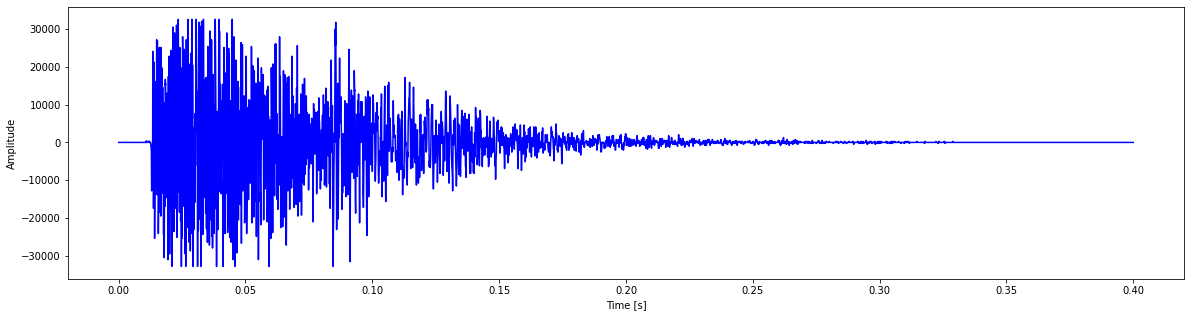

In [ ]:
##Comparação entre telhas boas e ruins 

plotDomainTime(dfBad,0,'red')
plotDomainTime(dfGood,0,'blue')
plotDomainTime(dfBad,35,'red')
plotDomainTime(dfGood,35,'blue')
plotDomainTime(dfBad,70,'red')
plotDomainTime(dfGood,70,'blue')
plotDomainTime(dfBad,105,'red')
plotDomainTime(dfGood,105,'blue')
plotDomainTime(dfBad,139,'red')
plotDomainTime(dfGood,139,'blue')

## As telhas ruims possuem uma amplitude inferior e perdem essa amplitude mais rapidamente no inicio do audio.
## As telhas boas possuem uma amplitude maior e essa amplitude permanece por mais tempo em relação as telhas quebradas.


In [ ]:
##Função para plot no domínio da frequência
def plotDomainFrequency(df,index,color):
    plt.figure(figsize=(20, 5))
    plt.plot(np.fft.rfftfreq(df['data'][index].shape[0], 1/44100), np.abs(np.fft.rfft(df['data'][index])),color=color)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.show()    

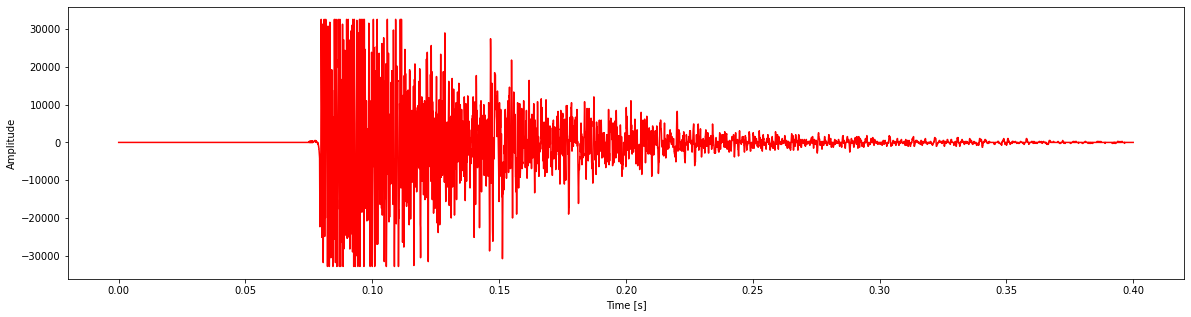

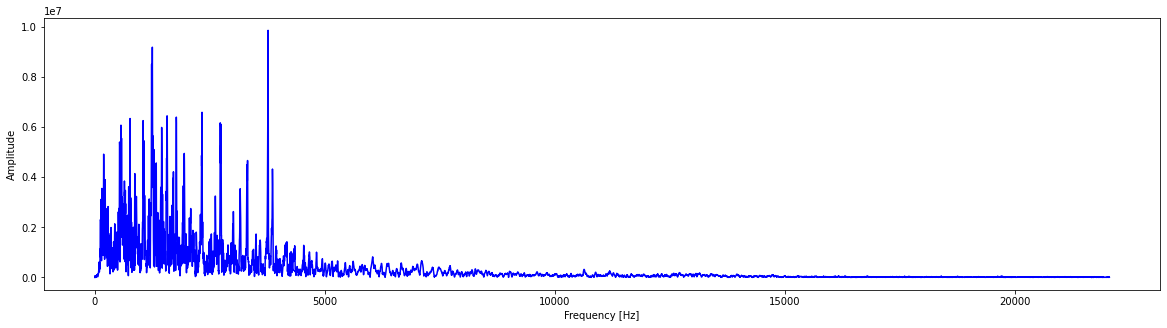

In [ ]:
##Demonstrativo dominio do tempo e frequência
plotDomainTime(dfGood,35,'red')
plotDomainFrequency(dfGood,35,'blue')


In [ ]:
# Importando modelos de classificação escolhidos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [ ]:
# Criando um dataframe com os audios bons e ruins
dfAll = pd.concat([dfGood,dfBad])

## Seleção das características 

Aplicar alguns dos métodos de seleção de características para selecionar 6 ou menos características para ser input do seu modelo 

obs: Você deverá normalizar os dados para que estejam em 'ranges' iguais 



Definição de X e Y 

In [ ]:
# Seleção das caracteristicas do dataframe
features = ['min','max','mean','force','rms','variance','form_factor','crest_factor','energy']
X = dfAll[features]
y = dfAll['good']
X

,min,max,mean,force,rms,variance,form_factor,crest_factor,energy
0,-32767,32511,-2.069261,-36419,6688,4.474096e+07,4.861094,-15711.403388,18608009
1,-32767,32511,2.457500,43252,6717,4.512923e+07,4.840107,13229.298067,16298932
2,-32767,32511,5.426193,95501,6063,3.676671e+07,5.362197,5991.493283,13397223
3,-32767,32511,-0.452330,-7961,6802,4.627718e+07,4.779624,-71874.588620,17529799
4,-32767,32511,-1.352614,-23806,6365,4.052156e+07,5.107777,-24035.688482,16493380
...,...,...,...,...,...,...,...,...,...
135,-32767,32511,-5.468125,-96239,5619,3.157507e+07,5.785905,-5945.548063,10214431
136,-32767,32511,-0.391023,-6882,4971,2.472055e+07,6.540133,-83143.504795,8112006
137,-32767,32511,-0.813352,-14315,4562,2.081451e+07,7.126480,-39971.610199,7075627
138,-32767,32511,0.232159,4086,5283,2.791101e+07,6.153890,140037.591777,9866688


In [ ]:
##Normalização dos dados
def normalizarDados(X,features): 
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    return X

In [ ]:
##Normalizando dados do X
XNormalizado = normalizarDados(X,features);
XNormalizado.head(3)

,min,max,mean,force,rms,variance,form_factor,crest_factor,energy
0,0.0,1.0,0.447190,0.447190,0.788543,0.728183,0.118572,0.049635,0.798200
1,0.0,1.0,0.596253,0.596253,0.795766,0.736927,0.114027,0.050308,0.676975
2,0.0,1.0,0.694010,0.694010,0.632877,0.548601,0.227081,0.050139,0.524638


In [ ]:
# Seleção das 6 melhores caracteristicas do dataframe
clf = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
feature_selection = RFE(clf, n_features_to_select=6, step=1)
fs = feature_selection.fit(XNormalizado, y)
suport = fs.support_

##Obtendo melhores caracteristicas para o array best_features
best_features = []
for i in range(len(suport)):
    if suport[i] == True:
        best_features.append(features[i])

best_features

['mean', 'rms', 'variance', 'form_factor', 'crest_factor', 'energy']

In [ ]:
##Normalizando dados do X novamente com as melhores caracteristicas
XNormalizado = dfAll[best_features]
XNormalizado = normalizarDados(XNormalizado,best_features)

In [ ]:
##Separando dados em teste e treino utilizando o método holdout (70 % para treino e 30% para teste)
X_train, X_test, y_train, y_test = train_test_split(XNormalizado, y, test_size=0.3, random_state=1)

## Criação do pipeline  (**pipe**)
## Definir quais os modelos e hiperparametros serão utilizados para rodar o pipeline.  (**search_space**)

  *  Selecionar 3 modelo de classificação. 
  *  Selecionar pelo menos 2 hiperparâmetro para busca em cada modelo.  


In [ ]:
##Criação da pipeline

pipe = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

search_space = [
    {
        'classifier': [DecisionTreeClassifier()],       #Hiperparametros da Arvore de decisão
        'classifier__max_depth': [3, 5, 10],            #Profundidade máxima de expansão da arvore se for "none" vai ate terminar as folhas
        'classifier__criterion': ['gini', 'entropy']    #Criterios da qualidade da divisão Gini para a impureza e Entropy igual a floresta para o ganho de informação
    },
    {
        'classifier': [RandomForestClassifier()],       #Hiperparametros da Floresta de decisão
        'classifier__max_depth': [3, 5, 10],            #Profundidade máxima de expansão das arvores default é none mesma que a arvore de decisao
        'classifier__criterion': ['gini', 'entropy'],   #Gini isolar num ramo os registros que representam a classe mais freqüente. Entropia, balanceia-se o número de registros em cada ramo.
        'classifier__n_estimators': [10, 50, 100]       #Número de árvores na floresta "100" como default
    },
    {
        'classifier': [KNeighborsClassifier()],         #Hiperparamtros de KNeighbors
        'classifier__n_neighbors': [5, 10, 15],         #Número de vizinhos "5" como default
        'classifier__weights': ['uniform', 'distance'], #Peso de cada vizinho uniform faz todos os pontos serem pesados da mesma forma distance pesa os pontos pelo inverso da sua distancia
        'classifier__metric': ['euclidean', 'manhattan']#Métrica de computação da distancia minkowski resulta na distância euclidiana padrão quando p = 2 
    }
]



## Criar GridSearch e passar como parâmetro:
  *  O pipeline criado anteriormente (**pipe**)
  *  O (**search_space**) contendo os modelos e hiperparâmetros a serem testados  
  *  1 método de validação cruzada (k-fold, leave one out ... etc) 

In [ ]:
##Criação do Grid Model

#O GridSearchCV é uma ferramenta usada para automatizar o processo de ajuste dos parâmetros de um algoritmo, pois ele fará de maneira 
#sistemática diversas combinações dos parâmetros e depois de avaliá-los os armazenará num único objeto.

grid_model = GridSearchCV(estimator=pipe,             # O pipeline criado anteriormente (pipe)
                          param_grid=search_space,    # O (search_space) contendo os modelos e hiperparâmetros a serem testados
                          cv=5,
                          verbose=1)

models = grid_model.fit(X_train, y_train)

y_pred = models.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Ajustando 5 dobras para cada um dos 36 candidatos, totalizando 180 ajustes

In [ ]:
#Melhor score dentre os modelos
models.best_score_

0.948974358974359

In [ ]:
#Melhor modelo selecionado
models.best_estimator_

Pipeline(steps=[('classifier', KNeighborsClassifier(metric='euclidean'))])

## Avaliação do modelo 

*   Utilizar Acurácia, Precisão, Recall, F1-score para avaliar o modelo
*   Utilizar a matriz de confusão para avaliar o modelo

In [ ]:
##Recuperando métricas do modelo.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


In [ ]:
##Criando tabela com métricas
df_metrics = pd.DataFrame({'Accuracy': [accuracy] ,
                            'Precision': [precision],
                            'Recall': [recall],
                            'F1': [f1]})
df_metrics

,Accuracy,Precision,Recall,F1
0,0.964286,0.95122,0.975,0.962963


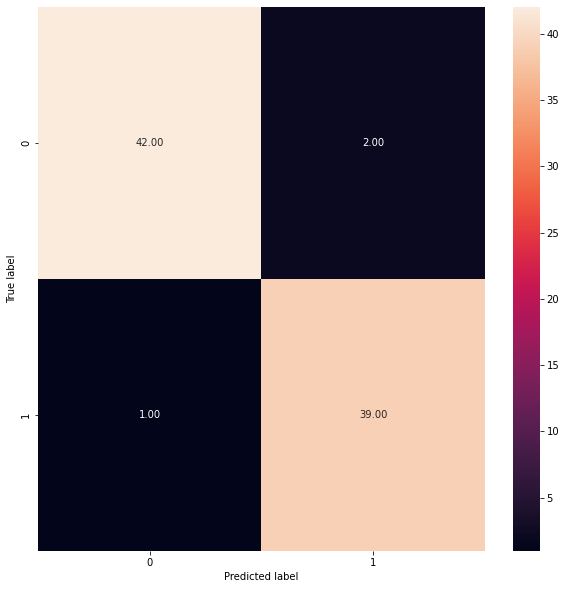

In [ ]:
##Criando matriz de confusão para identificar acertos do modelo.
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (10.0, 10.0)
sns.heatmap(cm, annot=True, fmt='.2f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
##Realizando uma predição com um novo registro.

newRegister = [
  -1.657955, #mean
  3973, #rms
  1.579228, #variance
  8.182985, #form_factor
  -19609.102125, #crest_factor
  5427976 #energy
]

predicao = models.predict([newRegister])[0]

if(predicao):
  print('Essa telha está BOA.')
else:
  print('Essa telha está RUIM')

Essa telha está BOA.


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
